In [288]:
import numpy as np
from gwbench import snr
from gwbench import waveform as wfc
from gwbench import injections
from gwbench import network
from gwbench import basic_relations as br
# from gwbench.snr import scalar_product_freq_array

import time

from pycbc import conversions as conv

from astropy.cosmology import Planck18, z_at_value

import gwbench_network_funcs as gwnet

from scipy.optimize import minimize
from scipy import optimize
from scipy import interpolate
from scipy import integrate

import lalsimulation as ls
import lal

from pycbc.types import FrequencySeries
from pycbc.filter import match
from pycbc.filter import matchedfilter
import pycbc.filter as fil

from pycbc import types, fft, waveform


In [86]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 14
})

%config InlineBackend.figure_format='retina' # very useful command for high-res images


In [447]:
def inner_prod_simps_normed(h1, h2, Sn, f, h1_norm = None, h2_norm=None):
    if h1_norm is None:
        h1_norm = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn, x=f))
    if h2_norm is None:
        h2_norm = 4*np.real(integrate.simpson(y= h2*np.conjugate(h2) / Sn, x=f))
    return  4*np.real(integrate.simpson(y= h2*np.conjugate(h1) / Sn, x=f)) / (np.sqrt(h1_norm * h2_norm))

def inner_prod_simps(h1, h2, Sn, f):
    return  4*np.real(integrate.simpson(y= h2*np.conjugate(h1) / Sn, x=f))

def inner_prod(h1, h2, Sn, f):
    x=f
    y= h2*np.conjugate(h1) / Sn
    interp_func = interpolate.interp1d(x, y, kind='cubic')
    # Define the integration limits
    a = x[0]
    b = x[-1]
    result, error = integrate.quadrature(interp_func, a, b, maxiter=100)
    return 4*np.real(result)

def inner_prod_normed(h1, h2, Sn, f):
    x=f
    a = x[0]
    b = x[-1]

    y1= h1*np.conjugate(h1) / Sn
    interp_func1 = interpolate.interp1d(x, y1, kind='cubic')
    h1_norm, error = integrate.quadrature(interp_func1, a, b, maxiter=100)
    h1_norm = 4*np.real(h1_norm)

    y2= h2*np.conjugate(h2) / Sn
    interp_func2 = interpolate.interp1d(x, y2, kind='cubic')
    h2_norm, error = integrate.quadrature(interp_func2, a, b, maxiter=100)
    h2_norm = 4*np.real(h2_norm)

    y = h2*np.conjugate(h1) / Sn
    interp_func = interpolate.interp1d(x, y, kind='cubic')
    result, error = integrate.quadrature(interp_func, a, b, maxiter=100)

    return 4*np.real(result / (np.sqrt(h1_norm * h2_norm)))


def maximize_overlap(params, args):
    tc, phic = params
    inj_params, f_low, f_high, d_f, approx2, network_spec_d, h1, Sn, f, deriv_symbs_string = args
    if (np.abs(phic)>2*np.pi):
        return np.inf
    
    inj_params_opt = inj_params.copy()
    inj_params_opt['tc'] = tc
    inj_params_opt['phic'] = phic

    net_2_try = gwnet.get_network_response(inj_params=inj_params_opt, 
    deriv_symbs_string=deriv_symbs_string,
    f_min=f_low, f_max=f_high, d_f=d_f,
    approximant=approx2, network_spec=network_spec_d,
    calc_detector_responses=True, calc_derivs = False, calc_fisher=False)
    
    h2 = net_2_try.detectors[0].hf
    return 1- inner_prod_normed(h1, h2, Sn, f)



def cutler_vallisneri_overlap_vec(del_hf, delta_hf, psd, freqs):
    return np.array([ inner_prod(del_hf[deriv], delta_hf, psd, freqs) for deriv in del_hf ])

# def cutler_vallisneri_overlap_vec(del_hf, delta_hf, psd, freqs):
#     return np.array([ scalar_product_freq_array(del_hf[deriv], delta_hf, psd, freqs) for deriv in del_hf ])

# def scalar_product_freq_array(hf, gf, psd, freqs):
#     return np.real(integrate.simpson(scalar_product_integrand(hf, gf, psd), freqs))

# def scalar_product_integrand(hf, gf, psd):
#     temp = np.multiply(hf, np.conj(gf))
#     return 2 * np.divide(temp + np.conj(temp), psd)



# Arnab's Binary

In [320]:
network_label = 'HLV+'
 
inj_params = dict()
inj_params['Mc'] = 30.9
inj_params['eta'] = 0.247
inj_params['iota'] = np.pi/4
inj_params['chi1x'] = 0
inj_params['chi1y'] = 0
inj_params['chi1z'] = 0
inj_params['chi2x'] = 0
inj_params['chi2y'] = 0
inj_params['chi2z'] = 0
inj_params['DL'] = 475
inj_params['tc'] = 0
inj_params['phic'] = 0
inj_params['ra'] = np.pi/4
inj_params['dec'] = np.pi/4
inj_params['psi'] = np.pi/4
inj_params['gmst0'] = 0
inj_params['phiRef'] = 0

d_f = 1/16
# d_f = 2**-4
f_low = 10.
f_high = 2048.
f = np.arange(f_low, f_high, d_f)

conv_cos = ('iota','dec')
conv_log = ('Mc','DL')
 
deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi'
deriv_variables = ['log_Mc', 'eta', 'log_DL', 'tc', 'phic', 'cos_iota', 'ra', 'cos_dec', 'psi']

arnab_opt_bias = np.array([-1.31714324e-03, -2.53070629e-03, -1.29260647e-02, 2.33387974e-04, -2.43714891e-02, -8.23804703e-03, 4.42655777e-05, -1.40069160e-05, -2.42399781e-02])

arnab_unopt_bias = np.array([1.30937195e-02, 3.38632109e-02, 1.74124245e+00, -2.14910145e-03, 3.90542706e-01, 2.64436484e-01, -1.87088785e-03, 8.53396225e-04, -6.38689364e-02])

In [321]:
net_ap = network.Network(network_spec=network_label)

approximant = 'IMRPhenomD'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_ap.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})


use_rot = 0

net_ap.set_net_vars(
    f_=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    conv_cos=conv_cos, conv_log=conv_log,
    use_rot=use_rot
    )
net_ap.calc_wf_polarizations()
net_ap.calc_wf_polarizations_derivs_num(step=1e-11, method='central', order=2, n=1)
net_ap.setup_ant_pat_lpf_psds()
net_ap.calc_det_responses()
net_ap.calc_det_responses_derivs_num(step=1e-11, method='central', order=2, n=1)
net_ap.calc_snrs()
net_ap.calc_errors()

2023-12-23 17:57:31,347 - Network - INFO : Polarizations calculated.
2023-12-23 17:57:31,348 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-12-23 17:57:31,352 - Network - INFO : Polarizations calculated.
2023-12-23 17:57:35,394 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-12-23 17:57:35,416 - Network - INFO : PSDs loaded.
2023-12-23 17:57:35,420 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 17:57:35,430 - Network - INFO : Detector responses calculated.
2023-12-23 17:57:35,431 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-12-23 17:57:35,432 - Network - INFO :    A+_H
2023-12-23 17:57:38,489 - Network - INFO :    A+_L
2023-12-23 17:57:41,496 - Network - INFO :    V+_V
2023-12-23 17:57:44,522 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-12-23 17:57:44,527 - Network - INFO : SNRs calculated.
2023-12-23 17:57:44,527 - Network - INFO : Calculate errors (Fishe

In [336]:
net_tr = network.Network(network_spec=network_label)

approximant = 'IMRPhenomXAS'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_tr.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})


use_rot = 0

net_tr.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    conv_cos=conv_cos, conv_log=conv_log,
    use_rot=use_rot
    )
net_tr.calc_wf_polarizations()
net_tr.setup_ant_pat_lpf_psds()
net_tr.calc_det_responses()
net_tr.calc_snrs()
# net_tr.calc_errors()

2023-12-23 18:07:50,906 - Network - INFO : Polarizations calculated.
2023-12-23 18:07:50,931 - Network - INFO : PSDs loaded.
2023-12-23 18:07:50,936 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:07:50,955 - Network - INFO : Detector responses calculated.
2023-12-23 18:07:50,961 - Network - INFO : SNRs calculated.


In [323]:
print(net_ap.det_keys)
net_ap.errs

['A+_H', 'A+_L', 'V+_V']


{'log_Mc': 0.0017187466,
 'eta': 0.0019915034,
 'log_DL': 0.2422514,
 'tc': 0.00010920756,
 'phic': 1.2460911,
 'cos_iota': 0.2556456,
 'ra': 0.0065248096,
 'cos_dec': 0.0048397877,
 'psi': 0.64912903}

In [324]:
arnab_errs = net_ap.errs.copy()
arnab_errs['Mc'] = inj_params['Mc']* net_ap.errs['log_Mc']
arnab_errs['DL'] = inj_params['DL']* net_ap.errs['log_DL']
arnab_errs['iota'] = net_ap.errs['cos_iota']/np.sin(inj_params['iota'])
arnab_errs['dec'] = net_ap.errs['cos_dec']/np.sin(inj_params['dec'])
arnab_errs

{'log_Mc': 0.0017187466,
 'eta': 0.0019915034,
 'log_DL': 0.2422514,
 'tc': 0.00010920756,
 'phic': 1.2460911,
 'cos_iota': 0.2556456,
 'ra': 0.0065248096,
 'cos_dec': 0.0048397877,
 'psi': 0.64912903,
 'Mc': 0.05310927039245143,
 'DL': 115.06941318511963,
 'iota': 0.361537478840935,
 'dec': 0.006844493440209816}

# Compute Unoptimized biases

In [303]:
overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

for d in range(len(net_ap.detectors)):
    ## set up initial waveforms
    h1 = net_tr.detectors[d].hf
    h2 = net_ap.detectors[d].hf
    f = net_ap.detectors[d].f
    Sn = net_ap.detectors[d].psd
    network_spec_d = [net_ap.detectors[d].det_key]

    ## Compute CV overlap vector for this detector
    delta_hf = net_tr.detectors[d].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)


cv_bias = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias = np.array(cv_bias.tolist()[0])

log_Mc: 8.850%
eta: 4.109%
log_DL: 0.639%
tc: -12.201%
phic: 61.886%
cos_iota: 9.726%
ra: -8.197%
cos_dec: 6.296%
psi: -123.961%


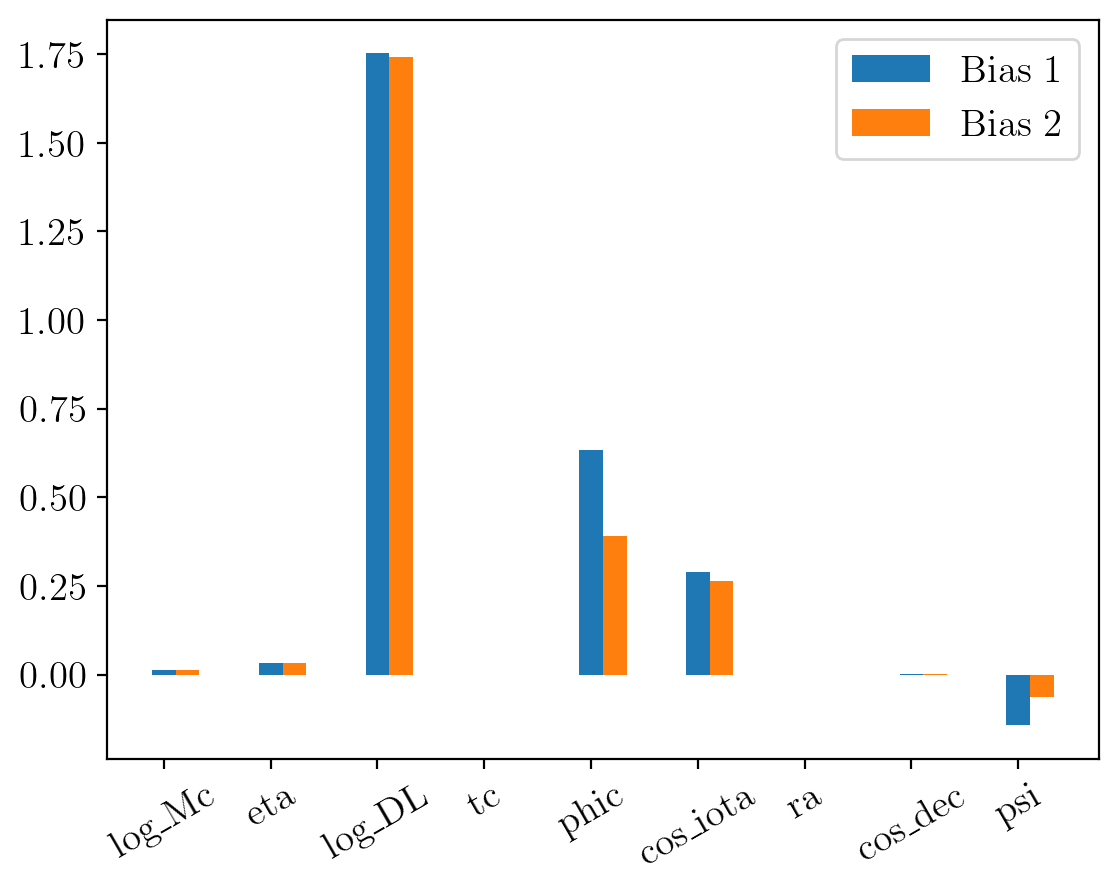

log_Mc, 1: 0.012 
log_Mc, 2: 0.013 

eta, 1: 0.032 
eta, 2: 0.034 

log_DL, 1: 1.752 
log_DL, 2: 1.741 

tc, 1: -0.002 
tc, 2: -0.002 

phic, 1: 0.632 
phic, 2: 0.391 

cos_iota, 1: 0.290 
cos_iota, 2: 0.264 

ra, 1: -0.002 
ra, 2: -0.002 

cos_dec, 1: 0.001 
cos_dec, 2: 0.001 

psi, 1: -0.143 
psi, 2: -0.064 



In [304]:
for n, bias in enumerate(100*np.abs(arnab_unopt_bias-cv_bias)/arnab_unopt_bias):
    print(f"{deriv_variables[n]}: {bias:.3f}%")

bias1 = cv_bias
bias2 = arnab_unopt_bias

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Bias 1')
plt.bar(x+width, bias2, width=width, label='Bias 2')

plt.xticks(x, deriv_variables, rotation=30)

plt.legend()
plt.show()

for i, param in enumerate(deriv_variables):
    print(f"{param}, 1: {bias1[i]:.3f} ")
    print(f"{param}, 2: {bias2[i]:.3f} ")
    print()

# Compute Optimized Biases

In [337]:
overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

# separate_det_opt = False
for d in range(len(net_ap.detectors)):

    ## set up initial waveforms
    h1 = net_tr.detectors[d].hf
    h2 = net_ap.detectors[d].hf
    f = net_ap.detectors[d].f
    Sn = net_ap.detectors[d].psd
    network_spec_d = [net_ap.detectors[d].det_key]


    ## optimize tc and phic
    args = [inj_params, f_low, f_high, d_f, 'IMRPhenomD', network_spec_d, h1, Sn, f, deriv_symbs_string]
    initial=[-0.01, -1.1]

    result = minimize(maximize_overlap, initial, args=args, method='BFGS', tol=1e-8)
    
    tc_opt, phic_opt = result.x
    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = -tc_opt
    inj_params_opt_d['phic'] = phic_opt
    
    
    net_tr_opt_d = network.Network(network_spec=network_spec_d)
    net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS'})
    net_tr_opt_d.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos, conv_log=conv_log,
        use_rot=use_rot
        )
    net_tr_opt_d.calc_wf_polarizations()
    net_tr_opt_d.setup_ant_pat_lpf_psds()
    net_tr_opt_d.calc_det_responses()
    net_tr_opt_d.calc_wf_polarizations()


    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)

cv_bias_opt = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias_opt = np.array(cv_bias_opt.tolist()[0])

2023-12-23 18:08:13,845 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:13,852 - Network - INFO : PSDs loaded.
2023-12-23 18:08:13,855 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:13,860 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:13,863 - Network - INFO : SNRs calculated.
2023-12-23 18:08:13,871 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:13,877 - Network - INFO : PSDs loaded.
2023-12-23 18:08:13,879 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:13,883 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:13,885 - Network - INFO : SNRs calculated.
2023-12-23 18:08:13,893 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:13,900 - Network - INFO : PSDs loaded.
2023-12-23 18:08:13,902 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:13,906 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:13,908 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:14,048 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:14,054 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,056 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,061 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:14,063 - Network - INFO : SNRs calculated.
2023-12-23 18:08:14,071 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:14,077 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,084 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:14,085 - Network - INFO : SNRs calculated.
2023-12-23 18:08:14,093 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:14,099 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,101 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,105 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:14,107 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:14,250 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:14,256 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,263 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:14,265 - Network - INFO : SNRs calculated.
2023-12-23 18:08:14,274 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:14,281 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,287 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:14,289 - Network - INFO : SNRs calculated.
2023-12-23 18:08:14,298 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:14,305 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,307 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,313 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:14,315 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:14,459 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,462 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,471 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:14,475 - Network - INFO : SNRs calculated.
2023-12-23 18:08:14,489 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:14,500 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,503 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,514 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:14,518 - Network - INFO : SNRs calculated.
2023-12-23 18:08:14,554 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:14,568 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,587 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:14,592 - Network - INFO : SNRs calculated.
2023-12-23 18:08:14,607 - Network - INFO : Polarizations calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:14,683 - Network - INFO : SNRs calculated.
2023-12-23 18:08:14,697 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:14,708 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,719 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:14,723 - Network - INFO : SNRs calculated.
2023-12-23 18:08:14,736 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:14,747 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,756 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:14,760 - Network - INFO : SNRs calculated.
2023-12-23 18:08:14,774 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:14,786 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,789 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,796 - Network - INFO : Detector responses calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:14,899 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,903 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,912 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:14,916 - Network - INFO : SNRs calculated.
2023-12-23 18:08:14,930 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:14,943 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:14,955 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:14,959 - Network - INFO : SNRs calculated.
2023-12-23 18:08:14,976 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:14,987 - Network - INFO : PSDs loaded.
2023-12-23 18:08:14,990 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:15,000 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:15,004 - Network - INFO : SNRs calculated.
2023-12-23 18:08:15,020 - Network - INFO : Polarizations calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:15,133 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:15,143 - Network - INFO : PSDs loaded.
2023-12-23 18:08:15,145 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:15,153 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:15,156 - Network - INFO : SNRs calculated.
2023-12-23 18:08:15,168 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:15,178 - Network - INFO : PSDs loaded.
2023-12-23 18:08:15,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:15,188 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:15,191 - Network - INFO : SNRs calculated.
2023-12-23 18:08:15,204 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:15,214 - Network - INFO : PSDs loaded.
2023-12-23 18:08:15,217 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:15,225 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:15,229 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:15,374 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:15,384 - Network - INFO : PSDs loaded.
2023-12-23 18:08:15,387 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:15,397 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:15,400 - Network - INFO : SNRs calculated.
2023-12-23 18:08:15,413 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:15,422 - Network - INFO : PSDs loaded.
2023-12-23 18:08:15,426 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:15,433 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:15,436 - Network - INFO : SNRs calculated.
2023-12-23 18:08:15,448 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:15,458 - Network - INFO : PSDs loaded.
2023-12-23 18:08:15,461 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:15,467 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:15,470 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:15,614 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:15,643 - Network - INFO : PSDs loaded.
2023-12-23 18:08:15,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:15,657 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:15,664 - Network - INFO : SNRs calculated.
2023-12-23 18:08:15,680 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:15,690 - Network - INFO : PSDs loaded.
2023-12-23 18:08:15,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:15,701 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:15,704 - Network - INFO : SNRs calculated.
2023-12-23 18:08:15,716 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:15,726 - Network - INFO : PSDs loaded.
2023-12-23 18:08:15,730 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:15,738 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:15,742 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:15,889 - Network - INFO : PSDs loaded.
2023-12-23 18:08:15,893 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:15,911 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:15,915 - Network - INFO : SNRs calculated.
2023-12-23 18:08:15,932 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:15,943 - Network - INFO : PSDs loaded.
2023-12-23 18:08:15,946 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:15,953 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:15,956 - Network - INFO : SNRs calculated.
2023-12-23 18:08:15,968 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:15,977 - Network - INFO : PSDs loaded.
2023-12-23 18:08:15,980 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:15,987 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:15,991 - Network - INFO : SNRs calculated.
2023-12-23 18:08:16,003 - Network - INFO : Polarizations calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:16,130 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:16,133 - Network - INFO : SNRs calculated.
2023-12-23 18:08:16,146 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:16,156 - Network - INFO : PSDs loaded.
2023-12-23 18:08:16,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:16,167 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:16,170 - Network - INFO : SNRs calculated.
2023-12-23 18:08:16,182 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:16,191 - Network - INFO : PSDs loaded.
2023-12-23 18:08:16,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:16,200 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:16,203 - Network - INFO : SNRs calculated.
2023-12-23 18:08:16,215 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:16,224 - Network - INFO : PSDs loaded.
2023-12-23 18:08:16,227 - Network - INFO : Antenna patterns and LPFs 

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:16,348 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:16,357 - Network - INFO : PSDs loaded.
2023-12-23 18:08:16,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:16,367 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:16,369 - Network - INFO : SNRs calculated.
2023-12-23 18:08:16,382 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:16,391 - Network - INFO : PSDs loaded.
2023-12-23 18:08:16,394 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:16,401 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:16,404 - Network - INFO : SNRs calculated.
2023-12-23 18:08:16,415 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:16,425 - Network - INFO : PSDs loaded.
2023-12-23 18:08:16,428 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:16,434 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:16,437 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:16,548 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:16,558 - Network - INFO : PSDs loaded.
2023-12-23 18:08:16,561 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:16,567 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:16,570 - Network - INFO : SNRs calculated.
2023-12-23 18:08:16,582 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:16,592 - Network - INFO : PSDs loaded.
2023-12-23 18:08:16,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:16,601 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:16,604 - Network - INFO : SNRs calculated.
2023-12-23 18:08:16,617 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:16,627 - Network - INFO : PSDs loaded.
2023-12-23 18:08:16,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:16,636 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:16,640 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:16,793 - Network - INFO : PSDs loaded.
2023-12-23 18:08:16,800 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:16,807 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:16,810 - Network - INFO : SNRs calculated.
2023-12-23 18:08:16,837 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:16,847 - Network - INFO : PSDs loaded.
2023-12-23 18:08:16,850 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:16,857 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:16,859 - Network - INFO : SNRs calculated.
2023-12-23 18:08:16,872 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:16,882 - Network - INFO : PSDs loaded.
2023-12-23 18:08:16,884 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:16,891 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:16,894 - Network - INFO : SNRs calculated.
2023-12-23 18:08:16,906 - Network - INFO : Polarizations calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:17,019 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:17,026 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:17,029 - Network - INFO : SNRs calculated.
2023-12-23 18:08:17,042 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:17,052 - Network - INFO : PSDs loaded.
2023-12-23 18:08:17,055 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:17,063 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:17,066 - Network - INFO : SNRs calculated.
2023-12-23 18:08:17,077 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:17,087 - Network - INFO : PSDs loaded.
2023-12-23 18:08:17,089 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:17,096 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:17,099 - Network - INFO : SNRs calculated.
2023-12-23 18:08:17,111 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:17,120 - Network - INFO : PSDs 

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:17,246 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:17,255 - Network - INFO : PSDs loaded.
2023-12-23 18:08:17,257 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:17,264 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:17,267 - Network - INFO : SNRs calculated.
2023-12-23 18:08:17,279 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:17,289 - Network - INFO : PSDs loaded.
2023-12-23 18:08:17,292 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:17,298 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:17,300 - Network - INFO : SNRs calculated.
2023-12-23 18:08:17,312 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:17,321 - Network - INFO : PSDs loaded.
2023-12-23 18:08:17,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:17,330 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:17,333 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:17,449 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:17,460 - Network - INFO : PSDs loaded.
2023-12-23 18:08:17,463 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:17,470 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:17,474 - Network - INFO : SNRs calculated.
2023-12-23 18:08:17,487 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:17,496 - Network - INFO : PSDs loaded.
2023-12-23 18:08:17,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:17,507 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:17,510 - Network - INFO : SNRs calculated.
2023-12-23 18:08:17,523 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:17,532 - Network - INFO : PSDs loaded.
2023-12-23 18:08:17,535 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:17,542 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:17,545 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:17,656 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:17,665 - Network - INFO : PSDs loaded.
2023-12-23 18:08:17,668 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:17,676 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:17,679 - Network - INFO : SNRs calculated.
2023-12-23 18:08:17,691 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:17,700 - Network - INFO : PSDs loaded.
2023-12-23 18:08:17,703 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:17,710 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:17,713 - Network - INFO : SNRs calculated.
2023-12-23 18:08:17,725 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:17,734 - Network - INFO : PSDs loaded.
2023-12-23 18:08:17,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:17,743 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:17,746 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 18:08:17,922 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.235624e+02
  warnings.warn(
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.099850e+02
  warnings.warn(
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.046279e-01
  warnings.warn(
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.764547e+02
  warnings.warn(
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.342987e-01
  warnings.wa

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:18,378 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:18,386 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:18,389 - Network - INFO : SNRs calculated.
2023-12-23 18:08:18,402 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:18,413 - Network - INFO : PSDs loaded.
2023-12-23 18:08:18,415 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:18,422 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:18,426 - Network - INFO : SNRs calculated.
2023-12-23 18:08:18,438 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:18,449 - Network - INFO : PSDs loaded.
2023-12-23 18:08:18,452 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:18,459 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:18,462 - Network - INFO : SNRs calculated.
2023-12-23 18:08:18,475 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:18,484 - Network - INFO : PSDs 

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:18,601 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:18,604 - Network - INFO : SNRs calculated.
2023-12-23 18:08:18,619 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:18,786 - Network - INFO : PSDs loaded.
2023-12-23 18:08:18,789 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:18,799 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:18,802 - Network - INFO : SNRs calculated.


['A+_L']
['A+_L']


2023-12-23 18:08:18,817 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:18,829 - Network - INFO : PSDs loaded.
2023-12-23 18:08:18,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:18,842 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:18,846 - Network - INFO : SNRs calculated.
2023-12-23 18:08:18,862 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:18,874 - Network - INFO : PSDs loaded.
2023-12-23 18:08:18,878 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:18,888 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:18,895 - Network - INFO : SNRs calculated.
2023-12-23 18:08:18,912 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:18,925 - Network - INFO : PSDs loaded.
2023-12-23 18:08:18,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:18,939 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:18,943 - Network - INFO : SNRs calc

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:19,058 - Network - INFO : PSDs loaded.
2023-12-23 18:08:19,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:19,068 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,071 - Network - INFO : SNRs calculated.
2023-12-23 18:08:19,084 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:19,094 - Network - INFO : PSDs loaded.
2023-12-23 18:08:19,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:19,103 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,107 - Network - INFO : SNRs calculated.
2023-12-23 18:08:19,119 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:19,130 - Network - INFO : PSDs loaded.
2023-12-23 18:08:19,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:19,140 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,143 - Network - INFO : SNRs calculated.
2023-12-23 18:08:19,155 - Network - INFO : Polarizations calc

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:19,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:19,285 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,288 - Network - INFO : SNRs calculated.
2023-12-23 18:08:19,301 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:19,311 - Network - INFO : PSDs loaded.
2023-12-23 18:08:19,314 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:19,321 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,325 - Network - INFO : SNRs calculated.
2023-12-23 18:08:19,337 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:19,348 - Network - INFO : PSDs loaded.
2023-12-23 18:08:19,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:19,358 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,362 - Network - INFO : SNRs calculated.
2023-12-23 18:08:19,375 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:19,386 - Network - INFO : PSDs 

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:19,512 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:19,522 - Network - INFO : PSDs loaded.
2023-12-23 18:08:19,527 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:19,536 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,539 - Network - INFO : SNRs calculated.
2023-12-23 18:08:19,564 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:19,574 - Network - INFO : PSDs loaded.
2023-12-23 18:08:19,577 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:19,584 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,587 - Network - INFO : SNRs calculated.
2023-12-23 18:08:19,600 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:19,612 - Network - INFO : PSDs loaded.
2023-12-23 18:08:19,615 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:19,623 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,627 - Network - INFO : SNRs calc

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:19,757 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:19,768 - Network - INFO : PSDs loaded.
2023-12-23 18:08:19,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:19,778 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,781 - Network - INFO : SNRs calculated.
2023-12-23 18:08:19,795 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:19,805 - Network - INFO : PSDs loaded.
2023-12-23 18:08:19,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:19,815 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,818 - Network - INFO : SNRs calculated.
2023-12-23 18:08:19,830 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:19,840 - Network - INFO : PSDs loaded.
2023-12-23 18:08:19,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:19,849 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,852 - Network - INFO : SNRs calc

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:19,954 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,957 - Network - INFO : SNRs calculated.
2023-12-23 18:08:19,970 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:19,981 - Network - INFO : PSDs loaded.
2023-12-23 18:08:19,984 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:19,991 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:19,994 - Network - INFO : SNRs calculated.
2023-12-23 18:08:20,008 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:20,019 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,022 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:20,029 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:20,032 - Network - INFO : SNRs calculated.
2023-12-23 18:08:20,044 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:20,054 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,058 - Network - INFO : Antenna patterns and LPFs 

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:20,171 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,174 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:20,183 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:20,187 - Network - INFO : SNRs calculated.
2023-12-23 18:08:20,204 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:20,216 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,219 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:20,227 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:20,231 - Network - INFO : SNRs calculated.
2023-12-23 18:08:20,245 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:20,255 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:20,266 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:20,269 - Network - INFO : SNRs calculated.
2023-12-23 18:08:20,282 - Network - INFO : Polarizations calc

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:20,433 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:20,436 - Network - INFO : SNRs calculated.
2023-12-23 18:08:20,470 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:20,483 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,486 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:20,497 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:20,500 - Network - INFO : SNRs calculated.
2023-12-23 18:08:20,514 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:20,526 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,529 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:20,537 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:20,541 - Network - INFO : SNRs calculated.
2023-12-23 18:08:20,554 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:20,566 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,569 - Network - INFO : Antenna patterns and LPFs 

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:20,652 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:20,665 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:20,668 - Network - INFO : SNRs calculated.
2023-12-23 18:08:20,681 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:20,692 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:20,701 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:20,704 - Network - INFO : SNRs calculated.
2023-12-23 18:08:20,717 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:20,727 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,729 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:20,736 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:20,739 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/s

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:20,878 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:20,882 - Network - INFO : SNRs calculated.
2023-12-23 18:08:20,896 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:20,908 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,911 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:20,918 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:20,921 - Network - INFO : SNRs calculated.
2023-12-23 18:08:20,934 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:20,944 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,947 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:20,955 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:20,958 - Network - INFO : SNRs calculated.
2023-12-23 18:08:20,971 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:20,981 - Network - INFO : PSDs loaded.
2023-12-23 18:08:20,983 - Network - INFO : Antenna patterns and LPFs 

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:21,093 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:21,101 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:21,104 - Network - INFO : SNRs calculated.
2023-12-23 18:08:21,118 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:21,129 - Network - INFO : PSDs loaded.
2023-12-23 18:08:21,132 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:21,138 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:21,142 - Network - INFO : SNRs calculated.
2023-12-23 18:08:21,154 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:21,164 - Network - INFO : PSDs loaded.
2023-12-23 18:08:21,167 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:21,173 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:21,176 - Network - INFO : SNRs calculated.
2023-12-23 18:08:21,188 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:21,198 - Network - INFO : PSDs 

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:21,312 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:21,316 - Network - INFO : SNRs calculated.
2023-12-23 18:08:21,331 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:21,341 - Network - INFO : PSDs loaded.
2023-12-23 18:08:21,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:21,352 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:21,355 - Network - INFO : SNRs calculated.
2023-12-23 18:08:21,367 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:21,377 - Network - INFO : PSDs loaded.
2023-12-23 18:08:21,380 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:21,388 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:21,392 - Network - INFO : SNRs calculated.
2023-12-23 18:08:21,404 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:21,416 - Network - INFO : PSDs loaded.
2023-12-23 18:08:21,419 - Network - INFO : Antenna patterns and LPFs 

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:21,526 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:21,533 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:21,535 - Network - INFO : SNRs calculated.
2023-12-23 18:08:21,548 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:21,558 - Network - INFO : PSDs loaded.
2023-12-23 18:08:21,561 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:21,567 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:21,570 - Network - INFO : SNRs calculated.
2023-12-23 18:08:21,596 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:21,629 - Network - INFO : PSDs loaded.
2023-12-23 18:08:21,655 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:21,678 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:21,682 - Network - INFO : SNRs calculated.
2023-12-23 18:08:21,696 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:21,706 - Network - INFO : PSDs 

['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:21,747 - Network - INFO : PSDs loaded.
2023-12-23 18:08:21,750 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:21,758 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:21,761 - Network - INFO : SNRs calculated.
2023-12-23 18:08:21,773 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:21,783 - Network - INFO : PSDs loaded.
2023-12-23 18:08:21,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:21,792 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:21,795 - Network - INFO : SNRs calculated.
2023-12-23 18:08:21,807 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:21,817 - Network - INFO : PSDs loaded.
2023-12-23 18:08:21,820 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:21,827 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:21,831 - Network - INFO : SNRs calculated.
2023-12-23 18:08:21,843 - Network - INFO : Polarizations calc

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:21,970 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:21,974 - Network - INFO : SNRs calculated.
2023-12-23 18:08:21,987 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:21,998 - Network - INFO : PSDs loaded.
2023-12-23 18:08:22,001 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:22,009 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:22,012 - Network - INFO : SNRs calculated.
2023-12-23 18:08:22,026 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:22,037 - Network - INFO : PSDs loaded.
2023-12-23 18:08:22,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:22,046 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:22,049 - Network - INFO : SNRs calculated.
2023-12-23 18:08:22,062 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:22,072 - Network - INFO : PSDs loaded.
2023-12-23 18:08:22,075 - Network - INFO : Antenna patterns and LPFs 

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:22,187 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:22,194 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:22,198 - Network - INFO : SNRs calculated.
2023-12-23 18:08:22,211 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:22,222 - Network - INFO : PSDs loaded.
2023-12-23 18:08:22,226 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:22,234 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:22,237 - Network - INFO : SNRs calculated.
2023-12-23 18:08:22,250 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:22,260 - Network - INFO : PSDs loaded.
2023-12-23 18:08:22,263 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:22,270 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:22,273 - Network - INFO : SNRs calculated.
2023-12-23 18:08:22,286 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:22,296 - Network - INFO : PSDs 

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:22,413 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:22,417 - Network - INFO : SNRs calculated.
2023-12-23 18:08:22,431 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:22,442 - Network - INFO : PSDs loaded.
2023-12-23 18:08:22,444 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:22,452 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:22,455 - Network - INFO : SNRs calculated.
2023-12-23 18:08:22,467 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:22,476 - Network - INFO : PSDs loaded.
2023-12-23 18:08:22,479 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:22,486 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:22,489 - Network - INFO : SNRs calculated.
2023-12-23 18:08:22,501 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:22,510 - Network - INFO : PSDs loaded.
2023-12-23 18:08:22,513 - Network - INFO : Antenna patterns and LPFs 

['A+_L']
['A+_L']
['A+_L']
['A+_L']
['A+_L']


2023-12-23 18:08:22,630 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.156540e+02
  warnings.warn(
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.809778e+02
  warnings.warn(
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.167278e+00
  warnings.warn(
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.728139e+03
  warnings.warn(
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.101839e+00
  warnings.wa

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:23,149 - Network - INFO : PSDs loaded.
2023-12-23 18:08:23,152 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:23,159 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:23,162 - Network - INFO : SNRs calculated.
2023-12-23 18:08:23,175 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:23,196 - Network - INFO : PSDs loaded.
2023-12-23 18:08:23,198 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:23,205 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:23,208 - Network - INFO : SNRs calculated.
2023-12-23 18:08:23,220 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:23,238 - Network - INFO : PSDs loaded.
2023-12-23 18:08:23,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:23,248 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:23,251 - Network - INFO : SNRs calculated.
2023-12-23 18:08:23,263 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:23,369 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:23,377 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:23,379 - Network - INFO : SNRs calculated.
2023-12-23 18:08:23,391 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:23,410 - Network - INFO : PSDs loaded.
2023-12-23 18:08:23,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:23,420 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:23,423 - Network - INFO : SNRs calculated.
2023-12-23 18:08:23,435 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:23,454 - Network - INFO : PSDs loaded.
2023-12-23 18:08:23,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:23,463 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:23,466 - Network - INFO : SNRs calculated.
2023-12-23 18:08:23,479 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:23,497 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:23,586 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:23,593 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:23,596 - Network - INFO : SNRs calculated.
2023-12-23 18:08:23,608 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:23,626 - Network - INFO : PSDs loaded.
2023-12-23 18:08:23,629 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:23,636 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:23,639 - Network - INFO : SNRs calculated.
2023-12-23 18:08:23,651 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:23,671 - Network - INFO : PSDs loaded.
2023-12-23 18:08:23,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:23,680 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:23,683 - Network - INFO : SNRs calculated.
2023-12-23 18:08:23,695 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:23,715 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:23,803 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:23,810 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:23,813 - Network - INFO : SNRs calculated.
2023-12-23 18:08:23,833 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:23,853 - Network - INFO : PSDs loaded.
2023-12-23 18:08:23,856 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:23,863 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:23,866 - Network - INFO : SNRs calculated.
2023-12-23 18:08:23,878 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:23,896 - Network - INFO : PSDs loaded.
2023-12-23 18:08:23,899 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:23,905 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:23,908 - Network - INFO : SNRs calculated.
2023-12-23 18:08:23,920 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:23,939 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:24,036 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:24,039 - Network - INFO : SNRs calculated.
2023-12-23 18:08:24,052 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:24,071 - Network - INFO : PSDs loaded.
2023-12-23 18:08:24,073 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:24,080 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:24,083 - Network - INFO : SNRs calculated.
2023-12-23 18:08:24,095 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:24,114 - Network - INFO : PSDs loaded.
2023-12-23 18:08:24,117 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:24,124 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:24,127 - Network - INFO : SNRs calculated.
2023-12-23 18:08:24,139 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:24,157 - Network - INFO : PSDs loaded.
2023-12-23 18:08:24,159 - Network - INFO : Antenna patterns and LPFs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:24,264 - Network - INFO : PSDs loaded.
2023-12-23 18:08:24,267 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:24,275 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:24,289 - Network - INFO : SNRs calculated.
2023-12-23 18:08:24,306 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:24,326 - Network - INFO : PSDs loaded.
2023-12-23 18:08:24,329 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:24,336 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:24,339 - Network - INFO : SNRs calculated.
2023-12-23 18:08:24,351 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:24,369 - Network - INFO : PSDs loaded.
2023-12-23 18:08:24,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:24,378 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:24,381 - Network - INFO : SNRs calculated.
2023-12-23 18:08:24,393 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:24,502 - Network - INFO : PSDs loaded.
2023-12-23 18:08:24,505 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:24,512 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:24,515 - Network - INFO : SNRs calculated.
2023-12-23 18:08:24,528 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:24,548 - Network - INFO : PSDs loaded.
2023-12-23 18:08:24,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:24,557 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:24,560 - Network - INFO : SNRs calculated.
2023-12-23 18:08:24,571 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:24,591 - Network - INFO : PSDs loaded.
2023-12-23 18:08:24,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:24,601 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:24,604 - Network - INFO : SNRs calculated.
2023-12-23 18:08:24,616 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:24,842 - Network - INFO : PSDs loaded.
2023-12-23 18:08:24,846 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:24,853 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:24,856 - Network - INFO : SNRs calculated.
2023-12-23 18:08:24,870 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:24,891 - Network - INFO : PSDs loaded.
2023-12-23 18:08:24,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:24,902 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:24,906 - Network - INFO : SNRs calculated.
2023-12-23 18:08:24,920 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:24,941 - Network - INFO : PSDs loaded.
2023-12-23 18:08:24,945 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:24,952 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:24,956 - Network - INFO : SNRs calculated.
2023-12-23 18:08:24,970 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:25,066 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:25,086 - Network - INFO : PSDs loaded.
2023-12-23 18:08:25,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:25,099 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:25,103 - Network - INFO : SNRs calculated.
2023-12-23 18:08:25,119 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:25,141 - Network - INFO : PSDs loaded.
2023-12-23 18:08:25,145 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:25,152 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:25,155 - Network - INFO : SNRs calculated.
2023-12-23 18:08:25,168 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:25,188 - Network - INFO : PSDs loaded.
2023-12-23 18:08:25,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:25,197 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:25,200 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:25,320 - Network - INFO : PSDs loaded.
2023-12-23 18:08:25,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:25,330 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:25,333 - Network - INFO : SNRs calculated.
2023-12-23 18:08:25,347 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:25,369 - Network - INFO : PSDs loaded.
2023-12-23 18:08:25,372 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:25,380 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:25,383 - Network - INFO : SNRs calculated.
2023-12-23 18:08:25,396 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:25,416 - Network - INFO : PSDs loaded.
2023-12-23 18:08:25,419 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:25,426 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:25,429 - Network - INFO : SNRs calculated.
2023-12-23 18:08:25,441 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:25,549 - Network - INFO : PSDs loaded.
2023-12-23 18:08:25,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:25,559 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:25,562 - Network - INFO : SNRs calculated.
2023-12-23 18:08:25,575 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:25,594 - Network - INFO : PSDs loaded.
2023-12-23 18:08:25,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:25,604 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:25,607 - Network - INFO : SNRs calculated.
2023-12-23 18:08:25,619 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:25,638 - Network - INFO : PSDs loaded.
2023-12-23 18:08:25,641 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:25,648 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:25,651 - Network - INFO : SNRs calculated.
2023-12-23 18:08:25,664 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:25,791 - Network - INFO : SNRs calculated.
2023-12-23 18:08:25,814 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:25,837 - Network - INFO : PSDs loaded.
2023-12-23 18:08:25,841 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:25,849 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:25,853 - Network - INFO : SNRs calculated.
2023-12-23 18:08:25,873 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:25,895 - Network - INFO : PSDs loaded.
2023-12-23 18:08:25,898 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:25,905 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:25,909 - Network - INFO : SNRs calculated.
2023-12-23 18:08:25,921 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:25,941 - Network - INFO : PSDs loaded.
2023-12-23 18:08:25,944 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:25,951 - Network - INFO : Detector responses calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:26,000 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:26,004 - Network - INFO : SNRs calculated.
2023-12-23 18:08:26,017 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:26,038 - Network - INFO : PSDs loaded.
2023-12-23 18:08:26,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:26,049 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:26,052 - Network - INFO : SNRs calculated.
2023-12-23 18:08:26,067 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:26,091 - Network - INFO : PSDs loaded.
2023-12-23 18:08:26,099 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:26,110 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:26,114 - Network - INFO : SNRs calculated.
2023-12-23 18:08:26,126 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:26,145 - Network - INFO : PSDs loaded.
2023-12-23 18:08:26,147 - Network - INFO : Antenna patterns and LPFs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:26,215 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:26,235 - Network - INFO : PSDs loaded.
2023-12-23 18:08:26,237 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:26,245 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:26,248 - Network - INFO : SNRs calculated.
2023-12-23 18:08:26,261 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:26,279 - Network - INFO : PSDs loaded.
2023-12-23 18:08:26,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:26,289 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:26,293 - Network - INFO : SNRs calculated.
2023-12-23 18:08:26,306 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:26,326 - Network - INFO : PSDs loaded.
2023-12-23 18:08:26,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:26,336 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:26,339 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:26,468 - Network - INFO : PSDs loaded.
2023-12-23 18:08:26,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:26,477 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:26,481 - Network - INFO : SNRs calculated.
2023-12-23 18:08:26,494 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:26,515 - Network - INFO : PSDs loaded.
2023-12-23 18:08:26,517 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:26,524 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:26,527 - Network - INFO : SNRs calculated.
2023-12-23 18:08:26,539 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:26,558 - Network - INFO : PSDs loaded.
2023-12-23 18:08:26,561 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:26,568 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:26,572 - Network - INFO : SNRs calculated.
2023-12-23 18:08:26,585 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:26,830 - Network - INFO : PSDs loaded.
2023-12-23 18:08:26,834 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:26,842 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:26,846 - Network - INFO : SNRs calculated.
2023-12-23 18:08:26,860 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:26,881 - Network - INFO : PSDs loaded.
2023-12-23 18:08:26,884 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:26,891 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:26,895 - Network - INFO : SNRs calculated.
2023-12-23 18:08:26,909 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:26,929 - Network - INFO : PSDs loaded.
2023-12-23 18:08:26,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:26,940 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:26,943 - Network - INFO : SNRs calculated.
2023-12-23 18:08:26,956 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:27,068 - Network - INFO : PSDs loaded.
2023-12-23 18:08:27,071 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:27,078 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:27,082 - Network - INFO : SNRs calculated.
2023-12-23 18:08:27,096 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:27,116 - Network - INFO : PSDs loaded.
2023-12-23 18:08:27,119 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:27,126 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:27,130 - Network - INFO : SNRs calculated.
2023-12-23 18:08:27,143 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:27,164 - Network - INFO : PSDs loaded.
2023-12-23 18:08:27,167 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:27,174 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:27,178 - Network - INFO : SNRs calculated.
2023-12-23 18:08:27,190 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:27,301 - Network - INFO : PSDs loaded.
2023-12-23 18:08:27,304 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:27,312 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:27,319 - Network - INFO : SNRs calculated.
2023-12-23 18:08:27,383 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:27,404 - Network - INFO : PSDs loaded.
2023-12-23 18:08:27,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:27,429 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:27,432 - Network - INFO : SNRs calculated.
2023-12-23 18:08:27,446 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:27,473 - Network - INFO : PSDs loaded.
2023-12-23 18:08:27,478 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:27,487 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:27,490 - Network - INFO : SNRs calculated.
2023-12-23 18:08:27,506 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:27,576 - Network - INFO : PSDs loaded.
2023-12-23 18:08:27,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:27,586 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:27,590 - Network - INFO : SNRs calculated.
2023-12-23 18:08:27,602 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:27,622 - Network - INFO : PSDs loaded.
2023-12-23 18:08:27,625 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:27,633 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:27,636 - Network - INFO : SNRs calculated.
2023-12-23 18:08:27,649 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:27,669 - Network - INFO : PSDs loaded.
2023-12-23 18:08:27,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:27,679 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:27,682 - Network - INFO : SNRs calculated.
2023-12-23 18:08:27,695 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:27,812 - Network - INFO : PSDs loaded.
2023-12-23 18:08:27,815 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:27,822 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:27,825 - Network - INFO : SNRs calculated.
2023-12-23 18:08:27,837 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:27,856 - Network - INFO : PSDs loaded.
2023-12-23 18:08:27,858 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:27,865 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:27,868 - Network - INFO : SNRs calculated.
2023-12-23 18:08:27,880 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:27,898 - Network - INFO : PSDs loaded.
2023-12-23 18:08:27,900 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:27,907 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:27,910 - Network - INFO : SNRs calculated.
2023-12-23 18:08:27,922 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:28,032 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:28,039 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:28,042 - Network - INFO : SNRs calculated.
2023-12-23 18:08:28,062 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:28,082 - Network - INFO : PSDs loaded.
2023-12-23 18:08:28,085 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:28,092 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:28,095 - Network - INFO : SNRs calculated.
2023-12-23 18:08:28,107 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:28,127 - Network - INFO : PSDs loaded.
2023-12-23 18:08:28,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:28,136 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:28,139 - Network - INFO : SNRs calculated.
2023-12-23 18:08:28,151 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:28,169 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:28,257 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:28,264 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:28,267 - Network - INFO : SNRs calculated.
2023-12-23 18:08:28,280 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:28,298 - Network - INFO : PSDs loaded.
2023-12-23 18:08:28,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:28,307 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:28,310 - Network - INFO : SNRs calculated.
2023-12-23 18:08:28,322 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:28,342 - Network - INFO : PSDs loaded.
2023-12-23 18:08:28,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:28,351 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:28,354 - Network - INFO : SNRs calculated.
2023-12-23 18:08:28,366 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:28,385 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:28,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:28,481 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:28,484 - Network - INFO : SNRs calculated.
2023-12-23 18:08:28,496 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:28,515 - Network - INFO : PSDs loaded.
2023-12-23 18:08:28,518 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:28,525 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:28,528 - Network - INFO : SNRs calculated.
2023-12-23 18:08:28,540 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:28,558 - Network - INFO : PSDs loaded.
2023-12-23 18:08:28,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:28,567 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:28,570 - Network - INFO : SNRs calculated.
2023-12-23 18:08:28,583 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:28,602 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:28,691 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:28,698 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:28,724 - Network - INFO : SNRs calculated.
2023-12-23 18:08:28,789 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:28,813 - Network - INFO : PSDs loaded.
2023-12-23 18:08:28,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:28,833 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:28,836 - Network - INFO : SNRs calculated.
2023-12-23 18:08:28,849 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:28,868 - Network - INFO : PSDs loaded.
2023-12-23 18:08:28,872 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:28,879 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:28,882 - Network - INFO : SNRs calculated.
2023-12-23 18:08:28,894 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:28,912 - Network - INFO : PSDs 

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:28,983 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:29,002 - Network - INFO : PSDs loaded.
2023-12-23 18:08:29,005 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:29,012 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:29,015 - Network - INFO : SNRs calculated.
2023-12-23 18:08:29,029 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:29,048 - Network - INFO : PSDs loaded.
2023-12-23 18:08:29,051 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:29,058 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:29,062 - Network - INFO : SNRs calculated.
2023-12-23 18:08:29,074 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:29,094 - Network - INFO : PSDs loaded.
2023-12-23 18:08:29,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:29,103 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:29,107 - Network - INFO : SNRs calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:29,225 - Network - INFO : PSDs loaded.
2023-12-23 18:08:29,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:29,235 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:29,238 - Network - INFO : SNRs calculated.
2023-12-23 18:08:29,250 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:29,270 - Network - INFO : PSDs loaded.
2023-12-23 18:08:29,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:29,280 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:29,283 - Network - INFO : SNRs calculated.
2023-12-23 18:08:29,295 - Network - INFO : Polarizations calculated.
2023-12-23 18:08:29,313 - Network - INFO : PSDs loaded.
2023-12-23 18:08:29,316 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:29,322 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:29,325 - Network - INFO : SNRs calculated.
2023-12-23 18:08:29,338 - Network - INFO : Polarizations calc

['V+_V']
['V+_V']
['V+_V']
['V+_V']


2023-12-23 18:08:29,447 - Network - INFO : PSDs loaded.
2023-12-23 18:08:29,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 18:08:29,459 - Network - INFO : Detector responses calculated.
2023-12-23 18:08:29,467 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.721343e+05
  warnings.warn(
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.748850e+04
  warnings.warn(
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.819971e+02
  warnings.warn(
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.7080

log_Mc: -818.397%
eta: -414.365%
log_DL: -12932.999%
tc: 256.958%
phic: -28139.179%
cos_iota: -2469.050%
ra: 16712.075%
cos_dec: -27195.330%
psi: -11538.683%


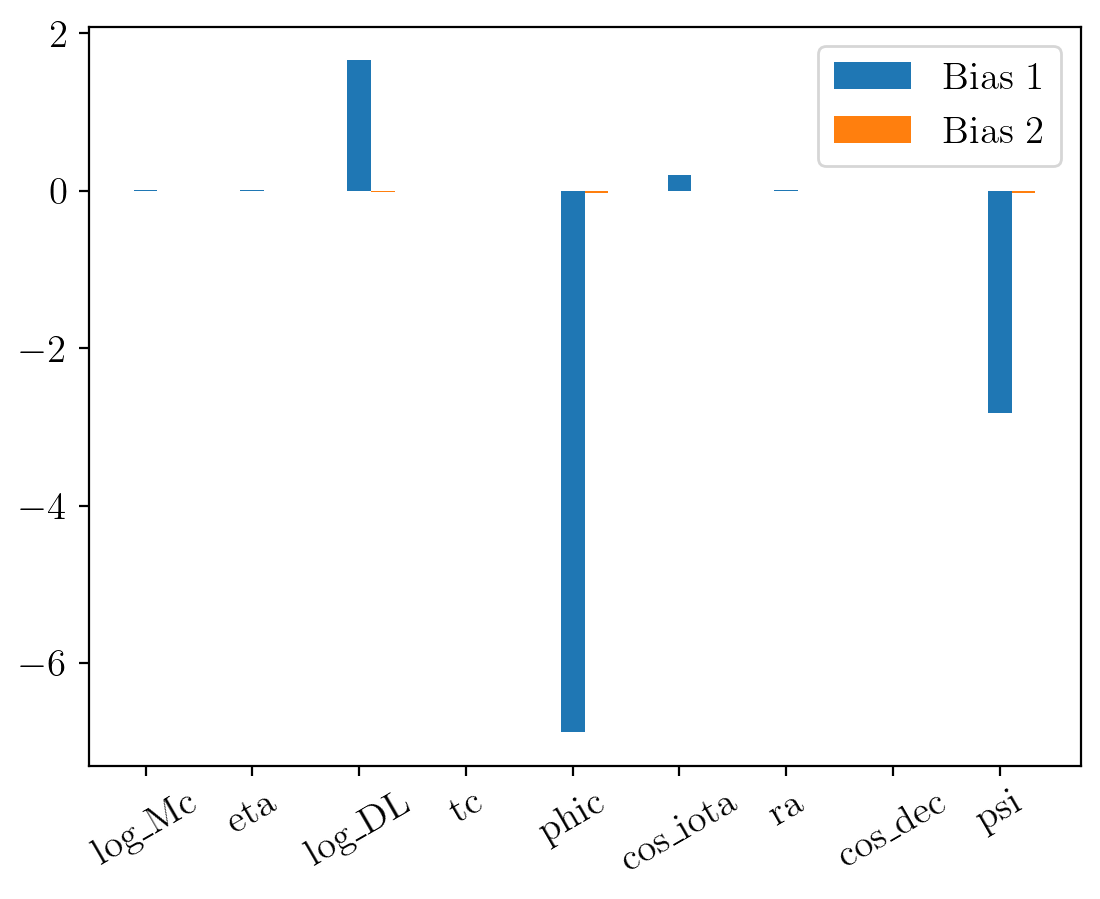

log_Mc, 1: 0.009 
log_Mc, 2: -0.001 

eta, 1: 0.008 
eta, 2: -0.003 

log_DL, 1: 1.659 
log_DL, 2: -0.013 

tc, 1: -0.000 
tc, 2: 0.000 

phic, 1: -6.882 
phic, 2: -0.024 

cos_iota, 1: 0.195 
cos_iota, 2: -0.008 

ra, 1: 0.007 
ra, 2: 0.000 

cos_dec, 1: 0.004 
cos_dec, 2: -0.000 

psi, 1: -2.821 
psi, 2: -0.024 



In [338]:
for n, bias in enumerate(100*np.abs(arnab_opt_bias-cv_bias_opt)/arnab_opt_bias):
    print(f"{deriv_variables[n]}: {bias:.3f}%")

bias1 = cv_bias_opt
bias2 = arnab_opt_bias

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Bias 1')
plt.bar(x+width, bias2, width=width, label='Bias 2')

plt.xticks(x, deriv_variables, rotation=30)

plt.legend()
plt.show()

for i, param in enumerate(deriv_variables):
    print(f"{param}, 1: {bias1[i]:.3f} ")
    print(f"{param}, 2: {bias2[i]:.3f} ")
    print()

# Compute Matched Filter Quantity

In [455]:
d = 0
h1 = net_tr.detectors[d].hf
h2 = net_ap.detectors[d].hf
f = net_ap.detectors[d].f
Sn = net_ap.detectors[d].psd
network_spec_d = [net_ap.detectors[d].det_key]

In [367]:
time_arr = np.linspace(-1., 1., 30001)
x_t0_re = np.zeros(len(time_arr))
x_t0_im = np.zeros(len(time_arr))

for i in range(len(time_arr)):
    t0 = time_arr[i]

    x_t0_re[i] = 4*np.real(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
    x_t0_im[i] = 4*np.imag(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))

In [372]:
max_idx = np.argmax(x_t0_re**2 + x_t0_im**2)
time_shift = time_arr[max_idx]
phase_shift = np.angle(x_t0_re + 1j*x_t0_im)[max_idx]/2

print(f"time shift: {time_shift} s")
print(f"phase shift: {phase_shift}")

time shift: 0.004533333333333278 s
phase shift: -1.0627039541296286


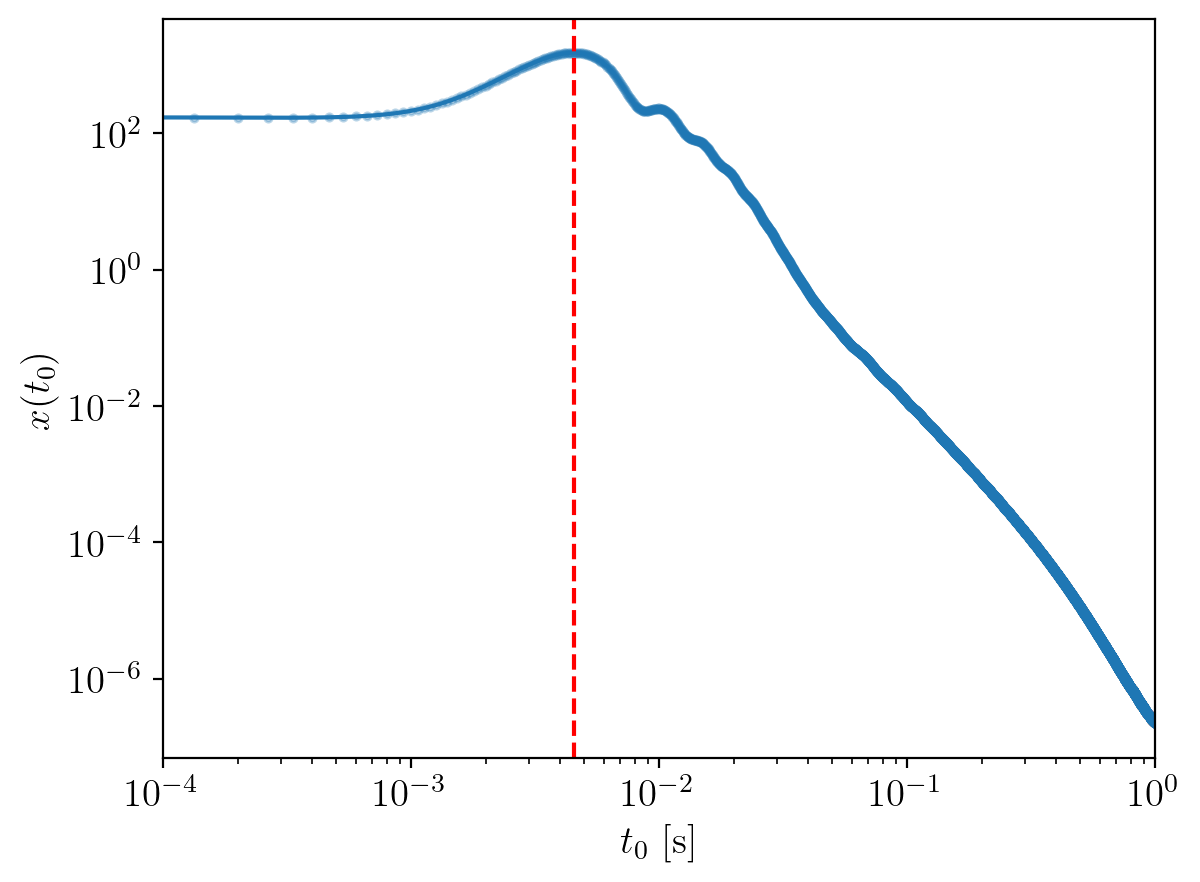

In [438]:
plt.plot(time_arr, x_t0_re**2 + x_t0_im**2)
plt.scatter(time_arr, x_t0_re**2 + x_t0_im**2, s=7, alpha=0.3)
plt.axvline(x=time_shift, ls='--', c='r')
plt.xlabel('$t_0$ [s]')
plt.ylabel("$x(t_0)$")
plt.loglog()
plt.xlim(1e-4, 1e0)
plt.show()

## Is this quantity ~overlap?

In [459]:
time_arr_ip = np.geomspace(1e-5, 1e1, 1000)
inner_prods_time = np.zeros(len(time_arr_ip))

for i in range(len(time_arr_ip)):

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = -time_arr_ip[i]
    inj_params_opt_d['phic'] = 0
    
    
    net_ap_time_shift = network.Network(network_spec=network_spec_d)
    net_ap_time_shift.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomD'})
    net_ap_time_shift.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos, conv_log=conv_log,
        use_rot=use_rot
        )
    net_ap_time_shift.calc_wf_polarizations()
    net_ap_time_shift.setup_ant_pat_lpf_psds()
    net_ap_time_shift.calc_det_responses()
    net_ap_time_shift.calc_wf_polarizations()

    h2 = net_ap_time_shift.detectors[d].hf

    inner_prods_time[i] = inner_prod_normed(h1, h2, Sn, f)
    

2023-12-23 19:05:54,447 - Network - INFO : Polarizations calculated.
2023-12-23 19:05:54,454 - Network - INFO : PSDs loaded.
2023-12-23 19:05:54,456 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 19:05:54,461 - Network - INFO : Detector responses calculated.
2023-12-23 19:05:54,467 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.221181e-04
  warnings.warn(
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.250548e-04
  warnings.warn(
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.747790e-04
  warnings.warn(
2023-12-23 19:05:54,526 - Network - INFO : Polarizations calculated.
2023-12-23 19:05:54,533 -

In [460]:
max_idx = np.argmax(np.abs(inner_prods_time))
max_idx
time_shift_ip = time_arr_ip[max_idx]

print(f"max overlap: {inner_prods_time[max_idx]}")
print(f"time shift: {time_shift_ip} s")

max overlap: -0.8395794942614897
time shift: 0.0033769803108250913 s


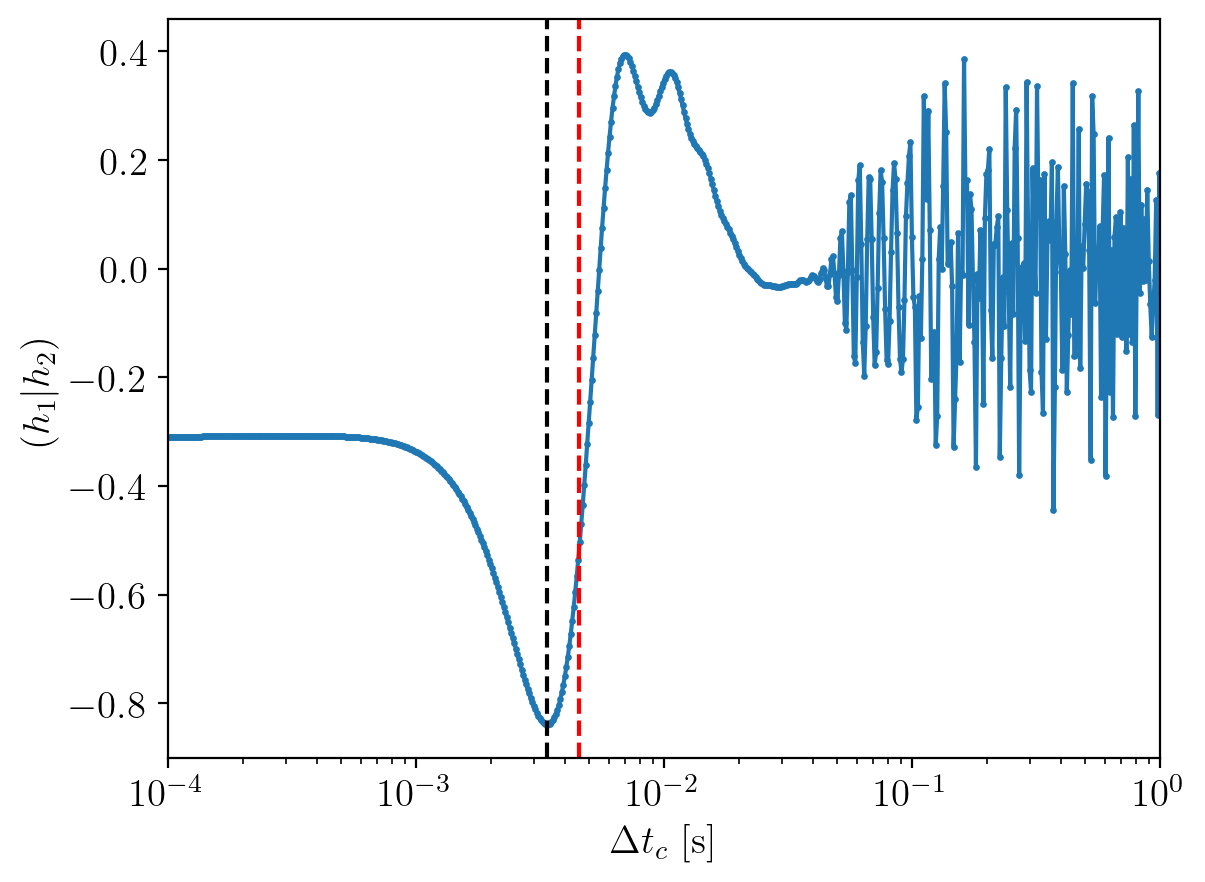

In [461]:
plt.scatter(time_arr_ip, inner_prods_time, s=2)
plt.plot(time_arr_ip, inner_prods_time)

plt.axvline(x=time_shift, ls='--', c='r')
plt.axvline(x=time_shift_ip, ls='--', c='k')

plt.xlabel('$\Delta t_c$ [s]')
plt.ylabel("$(h_1 | h_2)$")
plt.semilogx()
plt.xlim(1e-4, 1e0)
plt.show()

# Define integrations using Better methods

In [287]:
import numpy as np
from scipy import integrate
from scipy.interpolate import interp1d

# Sample data - replace this with your own dataset
x = np.arange(0, 10, 2**-4)
y = np.sin(x)

# Define an interpolating function using your data
analytic_result = np.cos(x[0]) - np.cos(x[-1])

# Perform integration using scipy.integrate.simpson
result= integrate.simpson(y, x=x)
print(f"Result of simpson integration: {result}")
print(f"Estimated error: {(analytic_result - result) / analytic_result}")

print()

# Perform integration using scipy.integrate.quadrature
interp_func = interp1d(x, y, kind='cubic')
# Define the integration limits
a = x[0]
b = x[-1]
result, error = integrate.quadrature(interp_func, a, b)
print(f"Result of interpolated quad integration: {result}")
print(f"Estimated error: {(analytic_result - result) / analytic_result}")

print()

# Actual Function
result, error = integrate.quadrature(np.sin, a, b)
print(f"Result of quad integration: {result}")
print(f"Estimated error: {(analytic_result - result) / analytic_result}")



Result of simpson integration: 1.8714169907009077
Estimated error: -2.4325630904375602e-06

Result of interpolated quad integration: 1.8714124062662385
Estimated error: 1.7155942747420198e-08

Result of quad integration: 1.8714124387389732
Estimated error: -1.9604982116957076e-10


In [106]:
network_label = 'HLV+'
 
inj_params = dict()
inj_params['Mc'] = 30.9
inj_params['eta'] = 0.247
inj_params['iota'] = np.pi/4
inj_params['chi1x'] = 0
inj_params['chi1y'] = 0
inj_params['chi1z'] = 0
inj_params['chi2x'] = 0
inj_params['chi2y'] = 0
inj_params['chi2z'] = 0
inj_params['DL'] = 475
inj_params['tc'] = 0
inj_params['phic'] = 0
inj_params['ra'] = np.pi/4
inj_params['dec'] = np.pi/4
inj_params['psi'] = np.pi/4
inj_params['gmst0'] = 0
inj_params['phiRef'] = 0

d_f = 1/16
f_low = 10.
f_high = 2048.
f = np.arange(f_low, f_high, d_f)

conv_cos = ('iota','dec')
conv_log = ('Mc','DL')
 
deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi'
deriv_variables = ['log_Mc', 'eta', 'log_DL', 'tc', 'phic', 'cos_iota', 'ra', 'cos_dec', 'psi']

arnab_opt_bias = np.array([-1.31714324e-03, -2.53070629e-03, -1.29260647e-02, 2.33387974e-04, -2.43714891e-02, -8.23804703e-03, 4.42655777e-05, -1.40069160e-05, -2.42399781e-02])

arnab_unopt_bias = np.array([1.30937195e-02, 3.38632109e-02, 1.74124245e+00, -2.14910145e-03, 3.90542706e-01, 2.64436484e-01, -1.87088785e-03, 8.53396225e-04, -6.38689364e-02])

In [107]:
net_ap = gwnet.get_network_response(inj_params=inj_params, 
    deriv_symbs_string=deriv_symbs_string,
    f_min=f_low, f_max=f_high, d_f=d_f,
    approximant='IMRPhenomD', network_spec=['A+_H'], 
    conv_cos = ('iota','dec'),
    conv_log = ('Mc','DL'),
    calc_derivs=False, calc_fisher=False
    )

net_tr = gwnet.get_network_response(inj_params=inj_params, 
    deriv_symbs_string=deriv_symbs_string,
    f_min=f_low, f_max=f_high, d_f=d_f,
    approximant='IMRPhenomXAS', network_spec=['A+_H'],
    conv_cos = ('iota','dec'),
    conv_log = ('Mc','DL'), 
    calc_derivs=False, calc_fisher=False
    )

h1 = net_tr.detectors[0].hf
h2 = net_ap.detectors[0].hf
f = net_ap.detectors[0].f
df = f[1]-f[0]
Sn = net_ap.detectors[0].psd

2023-12-23 16:34:25,576 - Network - INFO : Polarizations calculated.
2023-12-23 16:34:25,595 - Network - INFO : PSDs loaded.
2023-12-23 16:34:25,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:34:25,603 - Network - INFO : Detector responses calculated.
2023-12-23 16:34:25,606 - Network - INFO : SNRs calculated.
2023-12-23 16:34:25,614 - Network - INFO : Polarizations calculated.
2023-12-23 16:34:25,621 - Network - INFO : PSDs loaded.
2023-12-23 16:34:25,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:34:25,631 - Network - INFO : Detector responses calculated.
2023-12-23 16:34:25,634 - Network - INFO : SNRs calculated.


['A+_H']
['A+_H']


In [82]:
d_fs = [2**-1, 2**-2, 2**-3, 2**-4, 2**-5, 2**-6, 2**-7, 2**-8, 2**-9, 2**-10]

h_norms = np.zeros(len(d_fs))
h_norms_div = np.zeros(len(d_fs))

for i, d_f in enumerate(d_fs):
    net_ap = gwnet.get_network_response(inj_params=inj_params, 
        deriv_symbs_string=deriv_symbs_string,
        f_min=f_low, f_max=f_high, d_f=d_f,
        approximant='IMRPhenomD', network_spec=['A+_H'], 
        conv_cos = ('iota','dec'),
        conv_log = ('Mc','DL'),
        calc_derivs=False, calc_fisher=False
        )

    net_tr = gwnet.get_network_response(inj_params=inj_params, 
        deriv_symbs_string=deriv_symbs_string,
        f_min=f_low, f_max=f_high, d_f=d_f,
        approximant='IMRPhenomXAS', network_spec=['A+_H'],
        conv_cos = ('iota','dec'),
        conv_log = ('Mc','DL'), 
        calc_derivs=False, calc_fisher=False
        )


    h1 = net_tr.detectors[0].hf
    h2 = net_ap.detectors[0].hf
    f = net_ap.detectors[0].f
    df = f[1]-f[0]
    Sn = net_ap.detectors[0].psd

    h_norms[i] = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn, x=f))
    h_norms_div[i] = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn /h_norms[i], x=f))



2023-12-23 16:09:38,429 - Network - INFO : Polarizations calculated.
2023-12-23 16:09:38,437 - Network - INFO : PSDs loaded.
2023-12-23 16:09:38,439 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:09:38,442 - Network - INFO : Detector responses calculated.
2023-12-23 16:09:38,444 - Network - INFO : SNRs calculated.
2023-12-23 16:09:38,449 - Network - INFO : Polarizations calculated.
2023-12-23 16:09:38,464 - Network - INFO : PSDs loaded.
2023-12-23 16:09:38,465 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:09:38,470 - Network - INFO : Detector responses calculated.
2023-12-23 16:09:38,472 - Network - INFO : SNRs calculated.
2023-12-23 16:09:38,479 - Network - INFO : Polarizations calculated.
2023-12-23 16:09:38,486 - Network - INFO : PSDs loaded.
2023-12-23 16:09:38,487 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:09:38,490 - Network - INFO : Detector responses calculated.
2023-12-23 16:09:38,491 - Network - INFO : SNRs calc

['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']
['A+_H']


2023-12-23 16:09:38,637 - Network - INFO : PSDs loaded.
2023-12-23 16:09:38,641 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:09:38,648 - Network - INFO : Detector responses calculated.
2023-12-23 16:09:38,652 - Network - INFO : SNRs calculated.
2023-12-23 16:09:38,666 - Network - INFO : Polarizations calculated.
2023-12-23 16:09:38,675 - Network - INFO : PSDs loaded.
2023-12-23 16:09:38,680 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:09:38,688 - Network - INFO : Detector responses calculated.
2023-12-23 16:09:38,694 - Network - INFO : SNRs calculated.
2023-12-23 16:09:38,706 - Network - INFO : Polarizations calculated.
2023-12-23 16:09:38,715 - Network - INFO : PSDs loaded.
2023-12-23 16:09:38,720 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:09:38,732 - Network - INFO : Detector responses calculated.
2023-12-23 16:09:38,739 - Network - INFO : SNRs calculated.
2023-12-23 16:09:38,770 - Network - INFO : Polarizations calc

['A+_H']
['A+_H']
['A+_H']


2023-12-23 16:09:38,880 - Network - INFO : SNRs calculated.
2023-12-23 16:09:38,932 - Network - INFO : Polarizations calculated.
2023-12-23 16:09:38,956 - Network - INFO : PSDs loaded.
2023-12-23 16:09:38,970 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:09:38,998 - Network - INFO : Detector responses calculated.
2023-12-23 16:09:39,017 - Network - INFO : SNRs calculated.
2023-12-23 16:09:39,092 - Network - INFO : Polarizations calculated.


['A+_H']
['A+_H']


2023-12-23 16:09:39,115 - Network - INFO : PSDs loaded.
2023-12-23 16:09:39,148 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:09:39,208 - Network - INFO : Detector responses calculated.
2023-12-23 16:09:39,244 - Network - INFO : SNRs calculated.
2023-12-23 16:09:39,299 - Network - INFO : Polarizations calculated.
2023-12-23 16:09:39,320 - Network - INFO : PSDs loaded.
2023-12-23 16:09:39,357 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:09:39,421 - Network - INFO : Detector responses calculated.


['A+_H']


2023-12-23 16:09:39,462 - Network - INFO : SNRs calculated.
2023-12-23 16:09:39,628 - Network - INFO : Polarizations calculated.
2023-12-23 16:09:39,672 - Network - INFO : PSDs loaded.


['A+_H']


2023-12-23 16:09:39,731 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:09:39,835 - Network - INFO : Detector responses calculated.
2023-12-23 16:09:39,914 - Network - INFO : SNRs calculated.
2023-12-23 16:09:40,023 - Network - INFO : Polarizations calculated.
2023-12-23 16:09:40,055 - Network - INFO : PSDs loaded.
2023-12-23 16:09:40,107 - Network - INFO : Antenna patterns and LPFs loaded.


['A+_H']


2023-12-23 16:09:40,223 - Network - INFO : Detector responses calculated.
2023-12-23 16:09:40,291 - Network - INFO : SNRs calculated.


['A+_H']


2023-12-23 16:09:40,638 - Network - INFO : Polarizations calculated.
2023-12-23 16:09:40,715 - Network - INFO : PSDs loaded.
2023-12-23 16:09:40,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:09:40,972 - Network - INFO : Detector responses calculated.
2023-12-23 16:09:41,113 - Network - INFO : SNRs calculated.
2023-12-23 16:09:41,302 - Network - INFO : Polarizations calculated.


['A+_H']


2023-12-23 16:09:41,363 - Network - INFO : PSDs loaded.
2023-12-23 16:09:41,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-23 16:09:41,717 - Network - INFO : Detector responses calculated.
2023-12-23 16:09:41,842 - Network - INFO : SNRs calculated.


In [83]:
h_norms

array([39.23210456, 39.23189379, 39.23185863, 39.23188588, 39.23188829,
       39.23188904, 39.23188945, 39.23188926, 39.2318892 , 39.2318892 ])